# Download and install


In [34]:
%%capture out
## Warning: For windows environment
## Comment the magic command %%capture out at the top of this to 
## visualize the installation process.
## Downloading the dataset
!wget http://205.174.165.80/CICDataset/NSL-KDD/Dataset/NSL-KDD.zip -nc
!mkdir data
!mkdir results
!tar -xf NSL-KDD.zip -C data

## Installing dependencies
!pip install lime --quiet
!pip install shap --quiet

# Imports and paths

In [22]:
# Importing required libraries
import numpy as np
import pandas as pd
from os import path
import os

#Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Base path for the dataset
base_path=""
outputs_path= os.path.join(base_path, "results")
data_path = os.path.join(base_path, "data")


# Dataset description

The NSL-KDD dataset is a widely used benchmarking dataset in the network intrusion detection domain.

# Preparing the datast

In [23]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

class NSLKDD_data():
  """ Handle preprocessing and ouput a usable dataframe. Drops unnecessary columns,
  seperate continuous and categorical columns.

  Parameters
  ----------
  data_path (str) : Base path for the dataset folder

  Returns
  ----------
  None
  """
  def __init__(self, data_path):
    
    # NSL-KDD feature list
    self.FEATURES = ["duration","protocol_type","service","flag","src_bytes","dst_bytes",
              "land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
              "num_compromised","root_shell","su_attempted","num_root","num_file_creations",
              "num_shells","num_access_files","num_outbound_cmds","is_host_login",
              "is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
              "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate",
              "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
              "dst_host_diff_srv_rate","dst_host_same_src_port_rate",
              "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
              "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

    # (TBD) Multiclass classification labels
    self.MULTICLASS_ATTACK={ 'normal': ['normal'],
        'probe': ['ipsweep', 'nmap', 'portsweep','satan', 'saint', 'mscan'],
        'dos': ['back', 'land', 'neptune', 'pod', 'smurf','teardrop', 'apache2',
                'udpstorm', 'processtable','mailbomb'],
        'u2r': ['buffer_overflow', 'loadmodule', 'perl', 'rootkit','xterm', 'ps', 'sqlattack'],
        'r2l': ['ftp_write', 'guess_passwd', 'imap', 'multihop','phf', 'spy',
                'warezclient', 'warezmaster','snmpgetattack', 'named', 'xlock', 
                'xsnoop','sendmail', 'httptunnel', 'worm', 'snmpguess']}
    
    # path to the dataset
    self.DATA_PATH_TRAIN = os.path.join(data_path, "KDDTrain+.txt")
    self.DATA_PATH_TEST = os.path.join(data_path, "KDDTest+.txt")
    
    # Define the labels for binary classification
    self.NORMAL = 0
    self.ATTACK = 1
    
    self.full_X, self.full_y = self.read_nslkdd_dataset(self.DATA_PATH_TRAIN
                                                      , self.DATA_PATH_TEST
                                                      , self.FEATURES)
    self.encoder = OneHotEncoder(sparse=False)
  
  def _categorize_cols(self, df):
    # Binary numeric column names 
    #['land','logged_in','root_shell', 'su_attempted','is_host_login','is_guest_login']
    self.BINARY_COLS = self.get_binary_cols(df)

    # Non-binary string categorical column names
    # ['protocol_type','service','flag']
    self.CAT_COLS_STR_NB = self.get_categorical_str_cols(df)

    # Total Categorical columns
    #['protocol_type','service','flag','land','logged_in','root_shell','su_attempted',
    # 'is_host_login','is_guest_login']
    self.CAT_COLS = self.BINARY_COLS + self.CAT_COLS_STR_NB
    # Total Quantitative columns
    self.QUANT_COLS = [x for x in df.columns.to_list() if x not in self.CAT_COLS]
  
  def get_binary_cols(self, df):
    nunique_sr = df.select_dtypes(exclude=['object']).nunique() # numeric unique number of values
    return nunique_sr[nunique_sr <= 2].index.to_list()

  def get_categorical_str_cols(self, df):
    numeric_df = df.apply(pd.to_numeric, errors='ignore')
    # df.applymap(lambda x: isinstance(x, str)).all(0) 
    # (df.applymap(type) == str).all(0) # check col type for doing this
    return df.select_dtypes(include=['object']).columns.to_list()

  # Read both train and test data files ad concatenate into one dataframe
  def read_nslkdd_dataset(self, train_path, test_path, names):
    train_data = pd.concat([pd.read_csv(train_path, names=names), 
                            pd.read_csv(test_path, names=names)])
    labels = train_data['label']
    train_data.pop('label')
    return train_data, labels

  def _df_transformations(self, df):
    # Get one hot encoded categorical columns and normalize the numerical columns
    transformer = ColumnTransformer([('encoder', OneHotEncoder(),
                                      nsl_data.CAT_COLS_STR_NB), 
                                      ('normalizer', StandardScaler()
                                      , self.QUANT_COLS)],
                                      remainder='passthrough',
                                      verbose_feature_names_out=False)
    transformed_df = pd.DataFrame(transformer.fit_transform(df),
                                  columns=transformer.get_feature_names_out())
    return transformed_df

  def preprocess_data(self, classification='binary', split_ratio=0.25):
    """
    Handle preprocessing and ouput a usable dataframe. Drops unnecessary columns,
    seperate continuous and categorical columns.

    Parameters
    ----------
        classification : str
            Type of inference whether it is 'binary' or 'multi-class'
        split_ratio : float
            Train, test data split ratio
    Returns
    -------
        X_train (df): Training samples
        y_train (df): Training labels
        X_test (df):  Testing samples
        y_test (df): Testing labels
    """
    if self.full_X is not None:
      df = self.full_X
    else:
      print("Dataset is not read properly")

    # adjusting the label columns
    # (TBD) "else" for multiclass classification
    if classification == 'binary':
      bin_label = pd.DataFrame(self.full_y.map(
          lambda x:self.NORMAL if x=='normal' else self.ATTACK))
      
    #drop unnecessary features (outbound has only one value - recheck)
    df.drop(['difficulty'],axis=1,inplace=True)
    df.drop(['num_outbound_cmds'],axis=1,inplace=True)
      
    # correcting su_attempted
    df['su_attempted'].replace(to_replace=2, value=0, inplace=True)
    
    # Save column details
    self._categorize_cols(df) # categorizing the 40 columns

    # Standardize the continous features
    # Encode the categorical features
    df = self._df_transformations(df)

    # (TBD) Encode the labels for multiclass classification

    # Putting to canonical terms
    X_train, X_test, y_train, y_test = train_test_split(df, bin_label, test_size=split_ratio, random_state=40)
    return X_train, X_test, y_train, y_test

nsl_data = NSLKDD_data(data_path)
X_train, X_test, y_train, y_test = nsl_data.preprocess_data()


# Training the models

## Neural Network

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report # for generating a classification report of model
# for displaying confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [25]:
labels = ['Normal', 'Attack']
features = list(X_train.columns)

# Define the Keras model
model = Sequential()
model.add(Dense(12, input_shape=(121,), activation='relu'))
model.add(Dropout(.2))
model.add(Dense(7, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the Keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the Keras model on the dataset
history = model.fit(X_train, y_train, epochs=2, batch_size=10)


Train on 111387 samples
Epoch 1/2
111387/111387 [==============================] - 7s 64us/sample - loss: 0.1380 - accuracy: 0.9464
Epoch 2/2
111387/111387 [==============================] - 7s 63us/sample - loss: 0.0863 - accuracy: 0.9675


LSVM-Classifier Binary Set-Accuracy is  98.00700242391596
LSVM-Classifier MCC is  0.9600940806730324
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98     19204
      Attack       0.98      0.98      0.98     17926

    accuracy                           0.98     37130
   macro avg       0.98      0.98      0.98     37130
weighted avg       0.98      0.98      0.98     37130



Text(0.5, 1.0, 'Confusion Matrix')

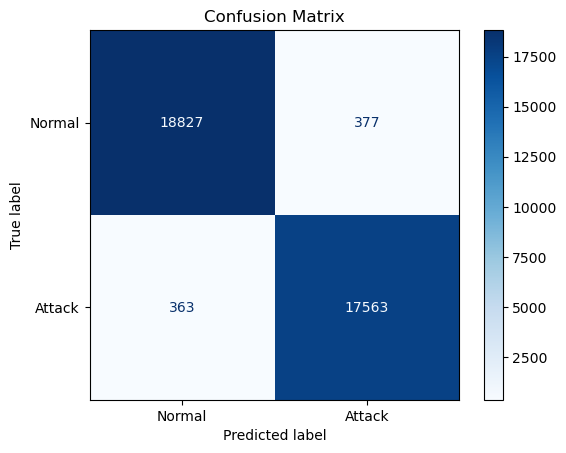

In [26]:
y_pred = model.predict(X_test) # predicting on testing dataset
y_pred = np.where(y_pred>0.5, 1, 0)
ac = accuracy_score(y_test, y_pred)*100 # calculating accuracy
print("LSVM-Classifier Binary Set-Accuracy is ", ac)
mcc = matthews_corrcoef(y_test, y_pred) # Calculating Mathews Correlation Coefficient
print("LSVM-Classifier MCC is ", mcc)

# classification report
print(classification_report(y_test, y_pred, target_names=labels))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

### Global explanations: SHAP

In [27]:
%%capture out
import shap
X_test_summary = shap.kmeans(X_test, 10)
explainer = shap.KernelExplainer(model.predict, X_test_summary)
shap_values = explainer.shap_values(X_test[:100], nsamples=100)


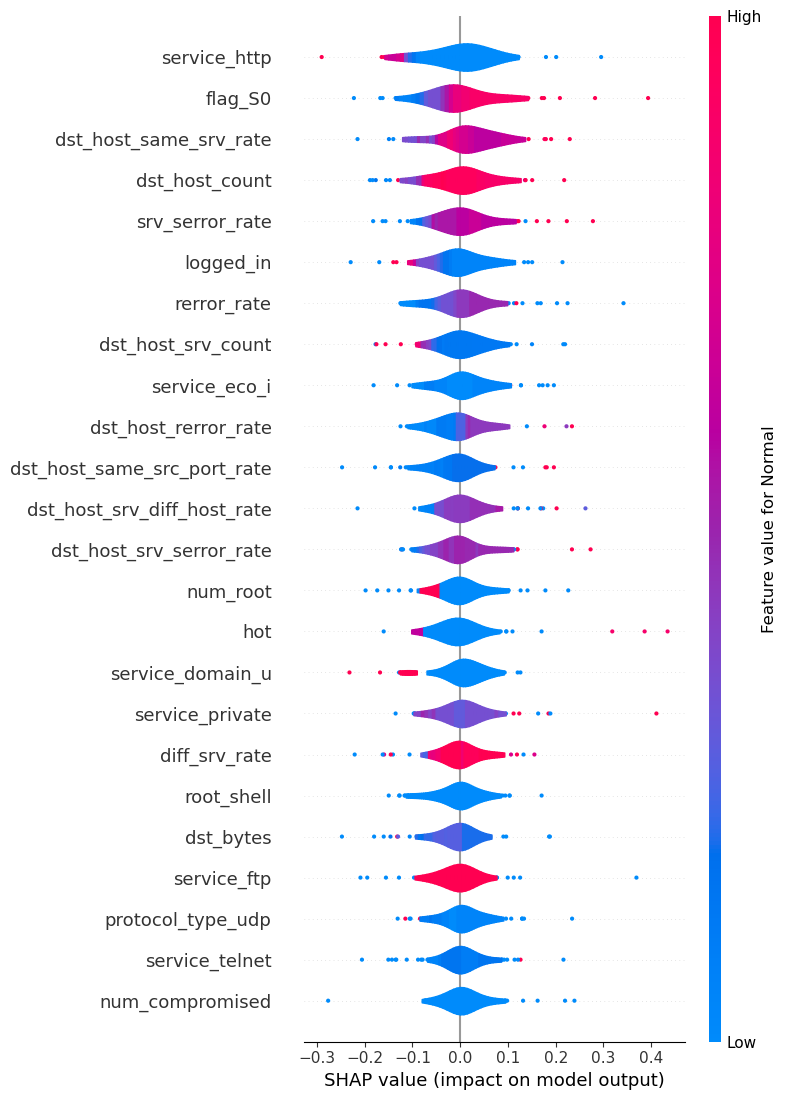

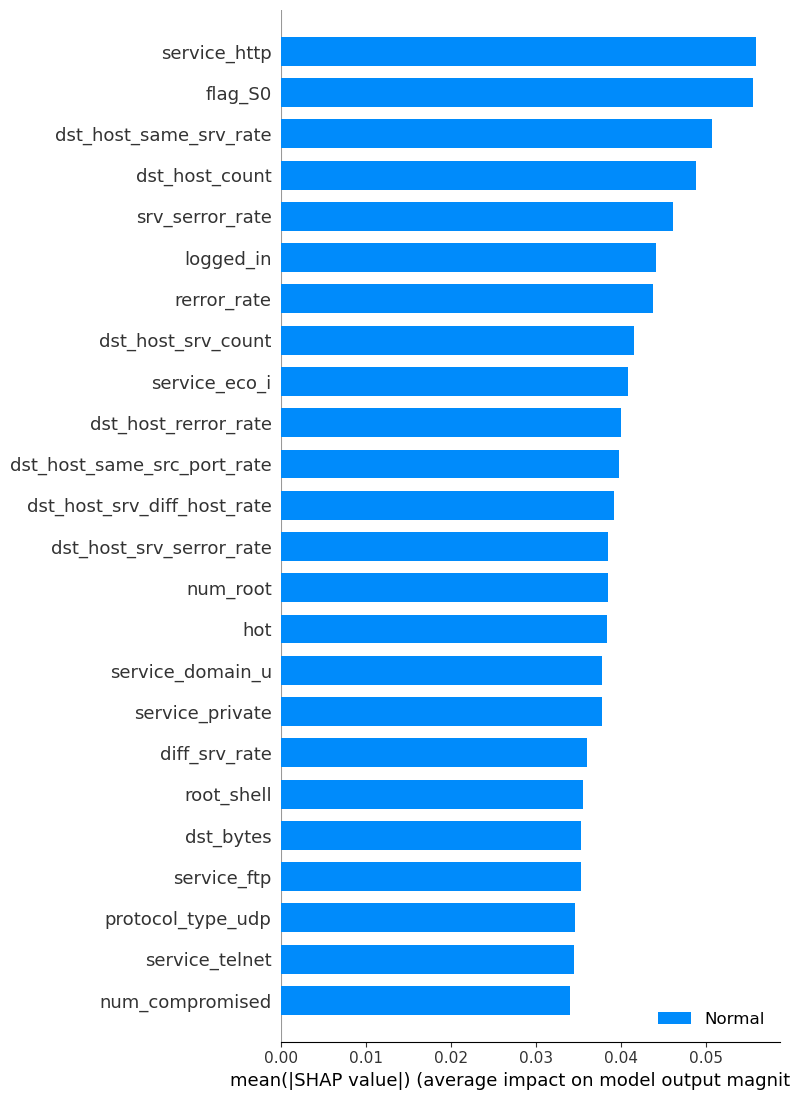

In [28]:
shap.summary_plot(shap_values[0], X_test[:100], feature_names=features, max_display=24, 
                    class_names=labels, color_bar_label='Feature value for Normal', plot_type="violin")

shap.summary_plot(shap_values, X_test[:100], feature_names=features, max_display=24, 
                    class_names=['Normal'], color_bar_label='Feature value for all')

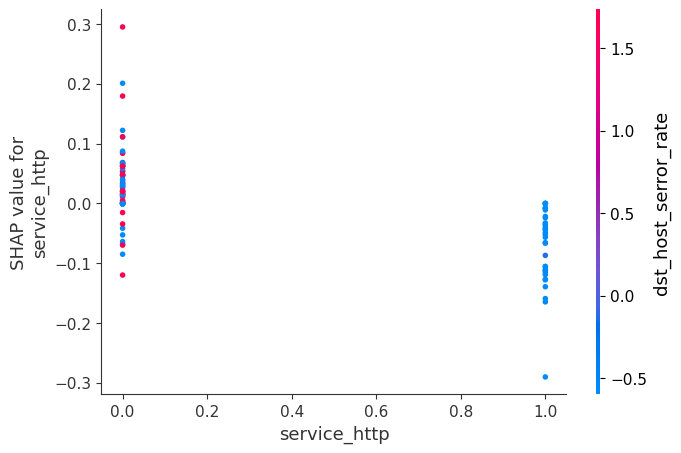

In [29]:
# Use the 'rank(i)' notation to get the plot of the i rank from the feature importance.
# Use the feature name as in the columns of the X_train df to see a specific feature
shap.dependence_plot("rank(0)", shap_values[0], X_test[:100])

In [31]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], features=features[:-1])

### Local Explanations: SHAP

In [33]:
shap.initjs()
i=201
shap_values = explainer.shap_values(X_test.values[i])
print("Actual target:", "Normal" if y_test.values[i]==1 else "Attack")
print("Base Value: ", explainer.expected_value[0])
shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names = features
                # ,matplotlib=True
                )

Actual target: Normal
Base Value:  0.4603385207654777


### Local Explanations: LIME

In [ ]:
import lime
import random

from lime import lime_tabular
from matplotlib import pyplot as plt

#idx = random.randint(0, len(X_test.values))
idx = 78
print("Local interpretation of sample " + str(idx + 1))
print("Prediction : ", model.predict(X_test.values[idx].reshape(1,-1)))
print("Actual :     ", y_test.values[idx])

classes=labels
predict_fn_nn= lambda x: model.predict(x)
lime_explainer = lime_tabular.LimeTabularExplainer(X_test.values, mode="classification", feature_names=features, feature_selection= 'auto',
                                                kernel_width=None, discretize_continuous=True, class_names=classes)
lime_explanation = lime_explainer.explain_instance(X_test.values[idx], predict_fn_nn, num_features=10, top_labels=3)
# explanation.as_pyplot_figure()

plt.tight_layout()
lime_explanation.show_in_notebook()

Local interpretation of sample 79
1/1 [==============================] - 0s 24ms/step
Prediction :  [[1.]]
Actual :      [1]
157/157 [==============================] - 0s 772us/step


<Figure size 640x480 with 0 Axes>